## Preparation des Donn√©es et Feature Engineering

- Ici l'objectuf c'est de pr√©parer les donn√©es COVID pour pr√©dire le nombre de nouveaux cas (new_cases)

## chargement des modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Chargement des donn√©es


      iso_code continent      country       date  total_cases  new_cases  \
12879      AFG      Asia  Afghanistan 2020-03-29           91         67   
6424       AFG      Asia  Afghanistan 2020-04-05          274        183   
12880      AFG      Asia  Afghanistan 2020-04-12          521        247   
0          AFG      Asia  Afghanistan 2020-04-19          908        387   
6425       AFG      Asia  Afghanistan 2020-04-26         1330        422   

       total_deaths  new_deaths  total_tests  positive_rate  ...  \
12879             2           2       518446           0.21  ...   
6424              5           3      6814263           0.05  ...   
12880            15          10      1716584           0.18  ...   
0                30          15      8796131           0.19  ...   
6425             43          13      7514673           0.30  ...   

       hospital_beds_per_thousand  extreme_poverty  new_vaccinations_smoothed  \
12879                         0.5            0.334   

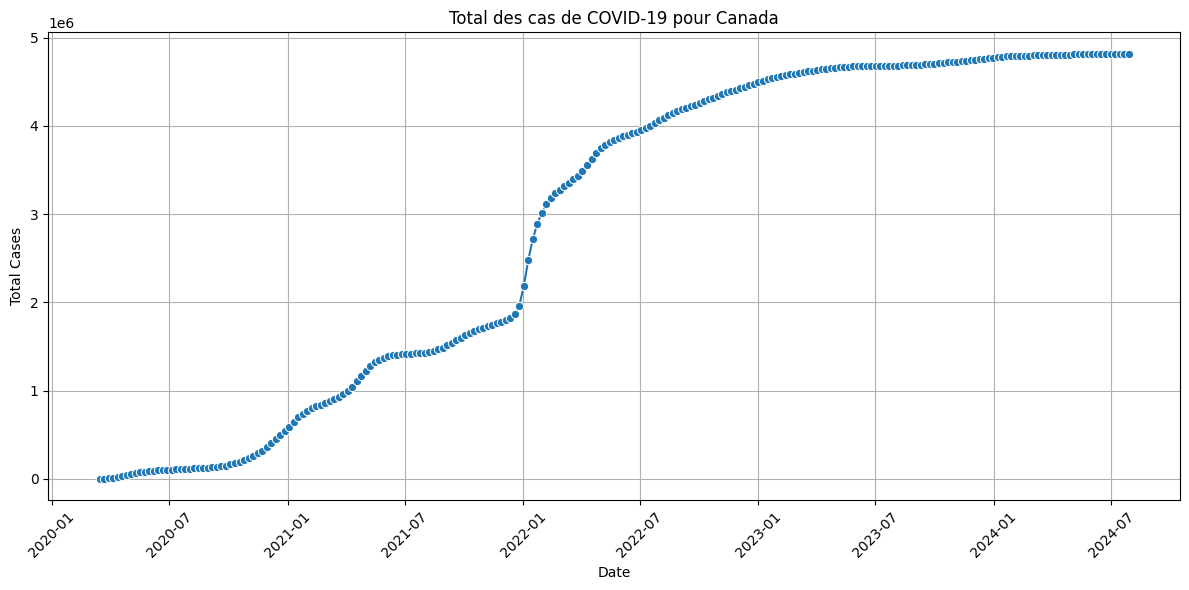

In [4]:
df = pd.read_csv("../dataset/clean_covid19_data_v2.csv", parse_dates=["date"])
df = df.sort_values(["country", "date"])
print(df.head()) # Afficher les premi√®res lignes du DataFrame
# fonction pour tracer les cas totaux de COVID-19 par pays x-date et y-total_cases
def plot_country_cases(df, country):
    country_data = df[df["country"] == country]
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=country_data, x="date", y="total_cases", marker='o')
    plt.title(f"Total des cas de COVID-19 pour {country}")
    plt.xlabel("Date")
    plt.ylabel("Total Cases")
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()
    
# Example usage 
plot_country_cases(df, "Canada")

## Filtrage d'un pays pour tester le processus
- Ce filtre peut √™tre adapt√© ensuite dans une boucle pour tous les pays

In [5]:
df_fr = df[df["country"] == "Canada"].copy()
df_fr.reset_index(drop=True, inplace=True)

## Cr√©ation des features temporelles
- On cr√©e des features temporelles pour capturer les tendances saisonni√®res et les effets de jour de la semaine sur les nouveaux cas

In [6]:
# Lags (retards) nous permettent de cr√©er des variables bas√©es sur les valeurs pass√©es
df_fr["new_cases_lag1"] = df_fr["new_cases"].shift(1)
df_fr["new_cases_lag7"] = df_fr["new_cases"].shift(7)

# Moyenne mobile 7 jours : ce champ permet de lisser les donn√©es pour mieux visualiser les tendances. c'est √† dire qu'on prend la moyenne des 7 derniers jours pour chaque jour.
df_fr["new_cases_ma7"] = df_fr["new_cases"].rolling(window=7).mean() 

# Taux de croissance des cas : c'est le pourcentage de variation des nouveaux cas par rapport au jour pr√©c√©dent.
df_fr["growth_rate"] = df_fr["new_cases"].pct_change().replace([np.inf, -np.inf], 0).fillna(0)

# Taux de vaccination (proportion)
df_fr["vaccinated_rate"] = df_fr["people_vaccinated"] / df_fr["population"]
df_fr["boosted_rate"] = df_fr["total_boosters"] / df_fr["population"]

##  S√©lection des variables utiles du mod√®le

In [7]:
features = [
    "new_cases_lag1", "new_cases_lag7", "new_cases_ma7", "growth_rate",
    "reproduction_rate", "positive_rate", "icu_patients", "hosp_patients",
    "stringency_index", "vaccinated_rate", "boosted_rate"
]
target = "new_cases"

## Visualisation rapide des nouvelles features

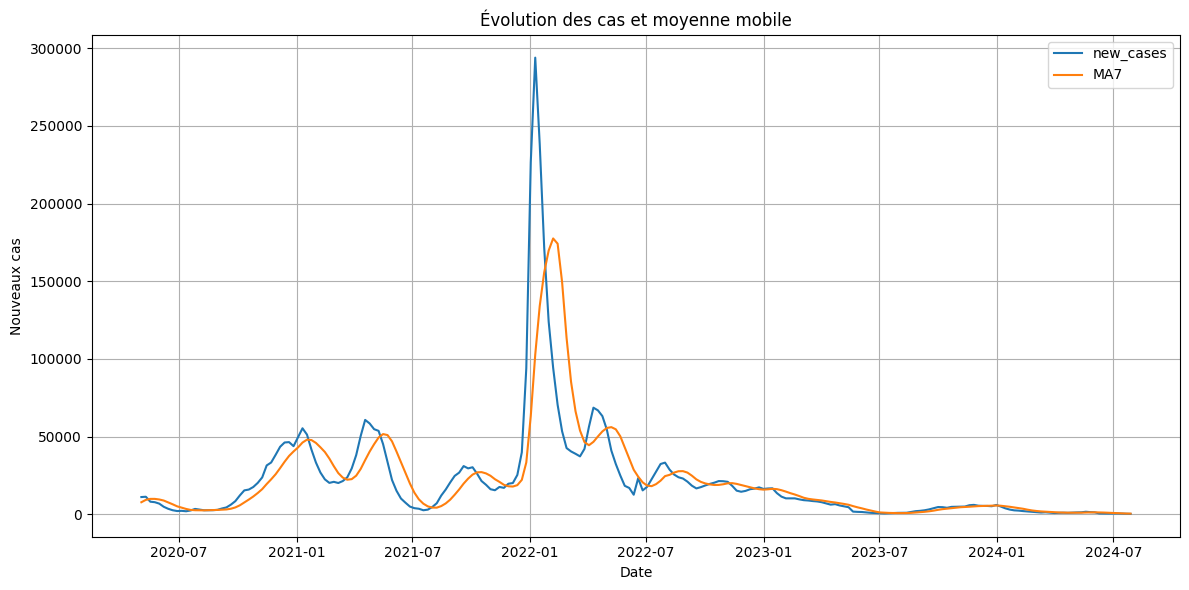

In [8]:
# Nettoyage au cas o√π certaines colonnes contiennent des NaN
df_model = df_fr[["date", "country"] + features + [target]].dropna()

plt.figure(figsize=(12,6))
plt.plot(df_model["date"], df_model["new_cases"], label="new_cases")
plt.plot(df_model["date"], df_model["new_cases_ma7"], label="MA7")
plt.title("√âvolution des cas et moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Nouveaux cas")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Export des donn√©es pr√©par√©es

In [121]:
df_model.to_csv("../dataset/prepared_canada_data.csv", index=False)
print("‚úÖ Donn√©es pr√©par√©es et export√©es pour mod√©lisation : prepared_canada_data.csv")

‚úÖ Donn√©es pr√©par√©es et export√©es pour mod√©lisation : prepared_canada_data.csv


##  Entra√Ænement du mod√®le de pr√©diction de cas COVID
- Entra√Æner un mod√®le pour pr√©dire les nouveaux cas √† partir des variables d√©riv√©es

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
%pip install joblib
import joblib

Note: you may need to restart the kernel to use updated packages.


## Chargement des donn√©es pr√©par√©es

In [9]:
df = pd.read_csv("../dataset/prepared_canada_data.csv", parse_dates=["date"])

# üîπ √âtape 2 : S√©paration des variables
features = [
    "new_cases_lag1", "new_cases_lag7", "new_cases_ma7", "growth_rate",
    "reproduction_rate", "positive_rate", "icu_patients", "hosp_patients",
    "stringency_index", "vaccinated_rate", "boosted_rate"
]
target = "new_cases"

X = df[features]
y = df[target]

## Split des donn√©es en train et test

In [ ]:
split_idx = int(len(df) * 0.8) 
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

## Entra√Ænement mod√®le Random Forest et pr√©dictions

In [11]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# üîπ √âtape 5 : Pr√©dictions
y_pred = model.predict(X_test)

## √âvaluation du mod√®le

In [14]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R¬≤ : {r2:.2f}")

MAE : 467.80
RMSE : 622.08
R¬≤ : 0.90


## üìä √âvaluation du Mod√®le ‚Äì Random Forest Regressor

### üéØ Objectif

L‚Äôobjectif du mod√®le est de pr√©dire le nombre de **nouveaux cas COVID-19** par jour en Afghanistan, en se basant sur l‚Äôhistorique √©pid√©miologique, les donn√©es de sant√© publique, les politiques sanitaires et la vaccination.

---

### üìà R√©sultats obtenus

| M√©trique | Valeur |
|----------|--------|
| MAE (Mean Absolute Error) | 467.80 |
| RMSE (Root Mean Squared Error) | 622.08 |
| R¬≤ (Coefficient de d√©termination) | 0.90 |

---

### Interpr√©tation

Nous avons observ√© les r√©sultats suivants pour le mod√®le Random Forest :

- **MAE ‚âà 467 cas** ‚Üí En moyenne, le mod√®le se trompe de 467 cas par jour.
- **RMSE ‚âà 622 cas** ‚Üí Les erreurs importantes sont bien p√©nalis√©es.
- **R¬≤ = 0.90** ‚Üí 90 % de la variance des nouveaux cas est expliqu√©e par les variables d‚Äôentr√©e.

Ces scores sont tr√®s encourageants compte tenu de la nature bruit√©e des donn√©es √©pid√©miologiques que nous traitons.

---

### üîé Analyse rapide

‚úÖ Les variables **lags (new_cases_lag1, lag7)**, les **moyennes mobiles**, et le **reproduction_rate** apportent une bonne capacit√© pr√©dictive.  
‚úÖ L‚Äôimpact du `stringency_index` (mesures sanitaires) semble significatif, surtout lors des vagues.  
‚ö†Ô∏è Cependant, les pics soudains (par exemple dus √† un changement de politique ou √† une crise sanitaire) peuvent rester difficiles √† pr√©voir.

---

### üõ†Ô∏è Pistes d‚Äôam√©lioration

1. **Ajout de variables temporelles**
   - `day_of_week` ou `month` : pour capturer les effets calendrier (ex : week-end, saisonnalit√©).
   - `holiday` (jours f√©ri√©s ou √©v√©nements majeurs) : peut expliquer certaines anomalies.

2. **Plus de contexte temporel**
   - Cr√©er une fen√™tre glissante (ex. 14 jours d‚Äôhistorique) pour chaque pr√©diction.
   - Tester un mod√®le s√©quentiel (LSTM ou GRU) si besoin de capturer dynamiques complexes.

3. **Meilleur nettoyage des donn√©es**
   - V√©rifier les `null`, `outliers`, ou valeurs anormalement basses (ex : 0 cas pendant des p√©riodes de pic).
   - R√©duction de bruit via transformation log ou z-score si donn√©es tr√®s variables.

4. **Tuning du mod√®le**
   - Actuellement, le mod√®le utilise `n_estimators=100` sans GridSearch.
   - On peut ajuster les param√®tres : `max_depth`, `min_samples_split`, `max_features`‚Ä¶

5. **Test sur plusieurs pays**
   - G√©n√©raliser le mod√®le √† d‚Äôautres pays pour tester sa robustesse.
   - Entra√Æner un mod√®le global, puis sp√©cialiser par pays.

6. **Stacking / mod√®les combin√©s**
   - Combiner XGBoost, RandomForest et LinearRegression avec une approche `stacking` pour profiter de leurs forces.

---

### üì¶ Conclusion

Le mod√®le Random Forest offre d√©j√† une **bonne performance de pr√©diction** (R¬≤ = 0.90), en capturant correctement les tendances.  
Cependant, des am√©liorations sont possibles pour affiner les pics et anticiper les changements rapides.  
Ces optimisations peuvent √™tre impl√©ment√©es par √©tapes, en gardant la version actuelle comme baseline fiable.

NB:
MAE (Mean Absolute Error) est la moyenne des erreurs absolues entre les valeurs pr√©dites et r√©elles.
RMSE (Root Mean Squared Error) est la racine carr√©e de la moyenne des carr√©s des erreurs.
R¬≤ (Coefficient de d√©termination) mesure la proportion de variance expliqu√©e par le mod√®le, allant de 0 (aucune explication) √† 1 (explication parfaite).

In [19]:
# Conclusion automatique :
if r2 > 0.7:
    interpretation = "Excellent - Le mod√®le explique bien la variance."
elif r2 > 0.5:
    interpretation = "Bon - Pr√©dictions acceptables, √† am√©liorer."
elif r2 > 0.3:
    interpretation = "Moyen - Le mod√®le capte partiellement les dynamiques."
else:
    interpretation = "Faible - Le mod√®le a du mal √† g√©n√©raliser."

print("\nüìà Conclusion :", interpretation)


üìà Conclusion : Excellent - Le mod√®le explique bien la variance.


## Visualisation des r√©sultats : Comparaison des pr√©dictions et des valeurs r√©elles

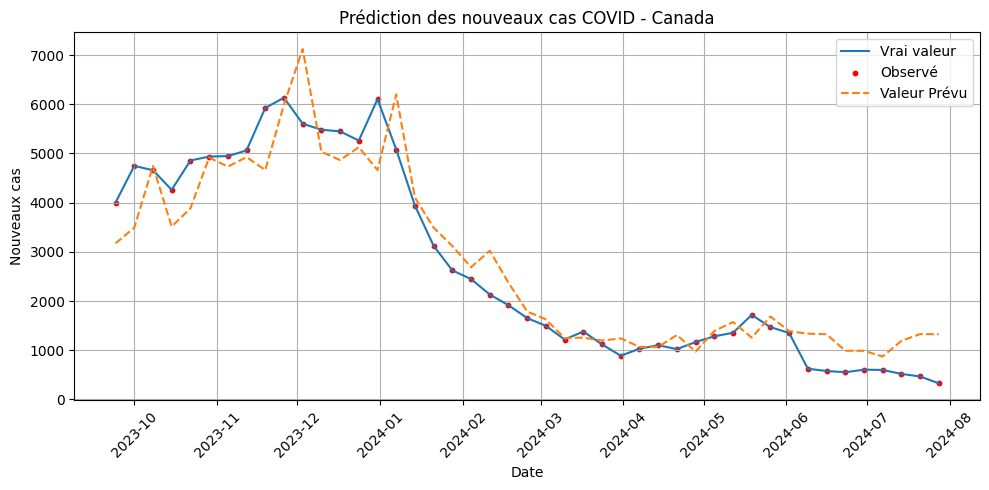

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(df["date"].iloc[split_idx:], y_test, label="Vrai valeur")
plt.scatter(df["date"].iloc[split_idx:], y_test, color='red', label="Observ√©", s=10)
plt.plot(df["date"].iloc[split_idx:], y_pred, label="Valeur Pr√©vu", linestyle="--")
plt.title("Pr√©diction des nouveaux cas COVID - Canada")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Nouveaux cas")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Sauvegarde du mod√®le

In [18]:
joblib.dump(model, "../model/rf_model_canada.joblib")
print("‚úÖ Mod√®le sauvegard√© : rf_model_canada.joblib")

‚úÖ Mod√®le sauvegard√© : rf_model_canada.joblib


# Am√©lioration du mod√®le